# Rock-Paper-Scissor Against Round Robin Policy

In [6]:
import numpy
import matplotlib.pyplot as plt
from learning_games import LearningGame

## Create game

In [7]:
class RPS_vs_round_robin:
    action_set={"R","P","S"}
    measurement_set={"R","P","S"}
    def __init__(self,action_sequence=["R","P","S"]):
        """Create game

        Args:
            action_sequence: sequence of actions for player 2
        """
        self.action_sequence=action_sequence
        self.last_action=len(self.action_sequence)-1
    def cost(self,p1_action,p2_action) -> float:
        """Returns game outcome

        Args:
            p1_action: action for player 1
            p2_action: action for player 2

        Returns:
            game result (float): -1 if player 1 wins, +1 if player 1 loses, 0 draw
        """
        if p1_action==p2_action:
            # draw
            return 0
        if (p1_action=="R" and p2_action=="S") or (p1_action=="P" and p2_action=="R") or (p1_action=="S" and p2_action=="P"):
            return -1
        else:
            return +1                
    def get_measurement(self):
        """get measurement for next game

        Returns:
            measurement: measurement for next game
        """
        return self.action_sequence[self.last_action]
    def play(self,p1_action) -> tuple[float,dict[str,float]]:      
        """Play game

        Args:
            p1_action: action for player 1

        Returns: 
            tuple[float,dict(str,float)]
            cost (float): -1 if player 1 wins, +1 if player 1 loses, 0 draw
            all_costs (dict[str,float]): dictionary with costs for all actions of player 1
        """
        # select action for player 2
        self.last_action += 1
        if self.last_action>=len(self.action_sequence):
            self.last_action=0
        p2_action=self.action_sequence[self.last_action]
        # cost for given action of player 1
        cost=self.cost(p1_action,p2_action)
        # costs for all actions of player 1
        all_costs={a:self.cost(a,p2_action) for a in self.action_set}
        return (cost,all_costs)
    

## Create LearningGame object

+ Against a static player, we can use `lambda=0`
+ Against a deterministic player, the temperature can be quite low. This will result in very fast learning.

In [8]:
game=RPS_vs_round_robin(action_sequence=["R","P","S"])
print(vars(game))
lg=LearningGame(game.action_set,measurement_set=game.measurement_set,
                              decay_rate=0.0,inverse_temperature=.1,seed=0);

{'action_sequence': ['R', 'P', 'S'], 'last_action': 2}


## Simulate game

In [9]:
lg.reset()
M = 1000
costs=numpy.zeros(M)
cost_bounds=numpy.zeros(M)
cost_bounds=numpy.zeros(M)
entropy=numpy.zeros(M)
for iter in range(M):
    # Play
    measurement=game.get_measurement()
    (action,_,entropy[iter])=lg.get_action(measurement,iter)
    (costs[iter],all_costs)=game.play(action)
    # Learn
    lg.update_energies(measurement, all_costs,iter)
    # Store regret
    (_,_,cost_bounds[iter],_,_,_,_,_)=lg.get_regret(display=False);
    # Output
    if iter<10:
        print("iter={:4d}, measurement = {:s}, action = {:s}, cost = {:2.0f}, all_costs = {:s}".format(iter,measurement,action,costs[iter],str(all_costs)))
    #print(lg.energy)
lg.get_regret(display=True);

iter=   0, measurement = S, action = R, cost =  0, all_costs = {'P': -1, 'R': 0, 'S': 1}
iter=   1, measurement = R, action = P, cost =  0, all_costs = {'P': 0, 'R': 1, 'S': -1}
iter=   2, measurement = P, action = P, cost =  1, all_costs = {'P': 1, 'R': -1, 'S': 0}
iter=   3, measurement = S, action = P, cost = -1, all_costs = {'P': -1, 'R': 0, 'S': 1}
iter=   4, measurement = R, action = S, cost = -1, all_costs = {'P': 0, 'R': 1, 'S': -1}
iter=   5, measurement = P, action = S, cost =  0, all_costs = {'P': 1, 'R': -1, 'S': 0}
iter=   6, measurement = S, action = R, cost =  0, all_costs = {'P': -1, 'R': 0, 'S': 1}
iter=   7, measurement = R, action = S, cost = -1, all_costs = {'P': 0, 'R': 1, 'S': -1}
iter=   8, measurement = P, action = R, cost = -1, all_costs = {'P': 1, 'R': -1, 'S': 0}
iter=   9, measurement = S, action = S, cost =  1, all_costs = {'P': -1, 'R': 0, 'S': 1}
  normalization_sum =   1000.000000  alpha1       =      0.998335  alpha0       =      0.083000
  minimum_cost

## Plot results

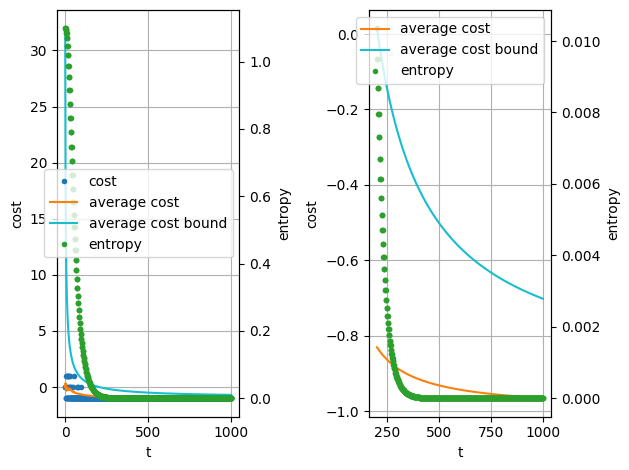

In [10]:
iters=range(M);
average_costs=numpy.divide(numpy.cumsum(costs),numpy.add(range(M),1))
average_cost_bounds=numpy.divide(numpy.cumsum(cost_bounds),numpy.add(range(M),1))
slc=slice(int(.2*M),M)
fig, ax=plt.subplots(1,2)
# Plot costs, average cost, and entropy, from start
ax_twin=ax[0].twinx()
lines=ax[0].plot(iters,costs,'.',label='cost',color='tab:blue')
lines+=ax[0].plot(iters,average_costs,'-',label='average cost',color='tab:orange')
lines+=ax[0].plot(iters,average_cost_bounds,'-',label='average cost bound',color='tab:cyan')
lines+=ax_twin.plot(iters,entropy,'.',label='entropy',color='tab:green')
ax[0].grid()
ax[0].set_xlabel('t')
ax[0].set_ylabel('cost')
ax_twin.set_ylabel('entropy')
leg=ax_twin.legend(lines,[line.get_label() for line in lines])
#  Plot costs, average cost, and entropy, skipping start
ax_twin=ax[1].twinx()
lines=ax[1].plot(iters[slc],average_costs[slc],'-',label='average cost',color='tab:orange')
lines+=ax[1].plot(iters[slc],average_cost_bounds[slc],'-',label='average cost bound',color='tab:cyan')
lines+=ax_twin.plot(iters[slc],entropy[slc],'.',label='entropy',color='tab:green')
leg=ax_twin.legend(lines,[line.get_label() for line in lines])
ax[1].grid()
ax[1].set_xlabel('t')
ax[1].set_ylabel('cost')
ax_twin.set_ylabel('entropy')
fig.tight_layout()
plt.show();